## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Input, Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.models import Model

In [6]:
""" 都不加
"""
def build_mlp(input_shape, output_units=10, num_neurons=[521, 256, 128]):
 
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu')(input_layer)

        else:
            x = Dense(units=n_units, activation='relu')(x)
        
    out = Dense(units=output_units, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[out])   
    
    return model

In [7]:
""" 加l1_l2
"""
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[521, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):

    input_layer = Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)

        else:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)

    out = Dense(units=output_units, activation='softmax')(x)

    model = Model(inputs=[input_layer], outputs=[out])   

    return model

In [8]:
""" 加dropout
"""
def build_mlp_l1_l2_drp(input_shape, output_units=10, num_neurons=[521, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4, drp_ratio=0.2):

    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
                      
    out = Dense(units=output_units, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[out])   
    
    return model

In [9]:
""" 加bn
"""
def build_mlp_l1_l2_drp_bn(input_shape, output_units=10, num_neurons=[521, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4, drp_ratio=0.2):

    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
                      
    out = Dense(units=output_units, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[out])   
    
    return model

In [10]:
""" 只有BN
"""
def build_mlp_bn(input_shape, output_units=10, num_neurons=[521, 256, 128]):

    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu')(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation='relu')(x)
            x = BatchNormalization()(x)
    
    out = Dense(units=output_units, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[out])   
    
    return model

In [11]:
""" Code Here
    設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 32
MODEL = [build_mlp, build_mlp_l1_l2, build_mlp_l1_l2_drp, build_mlp_l1_l2_drp_bn, build_mlp_bn]

In [12]:
results = {}
""" Code Here
    撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for m in MODEL:
    
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with model = %s" % str(m).split(' ')[1])
    model = m(input_shape=x_train.shape[1:])
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              verbose=0)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-model-%s" % str(m).split(' ')[1]
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}



Experiment with model = build_mlp
Experiment with model = build_mlp_l1_l2
Experiment with model = build_mlp_l1_l2_drp
Experiment with model = build_mlp_l1_l2_drp_bn
Experiment with model = build_mlp_bn


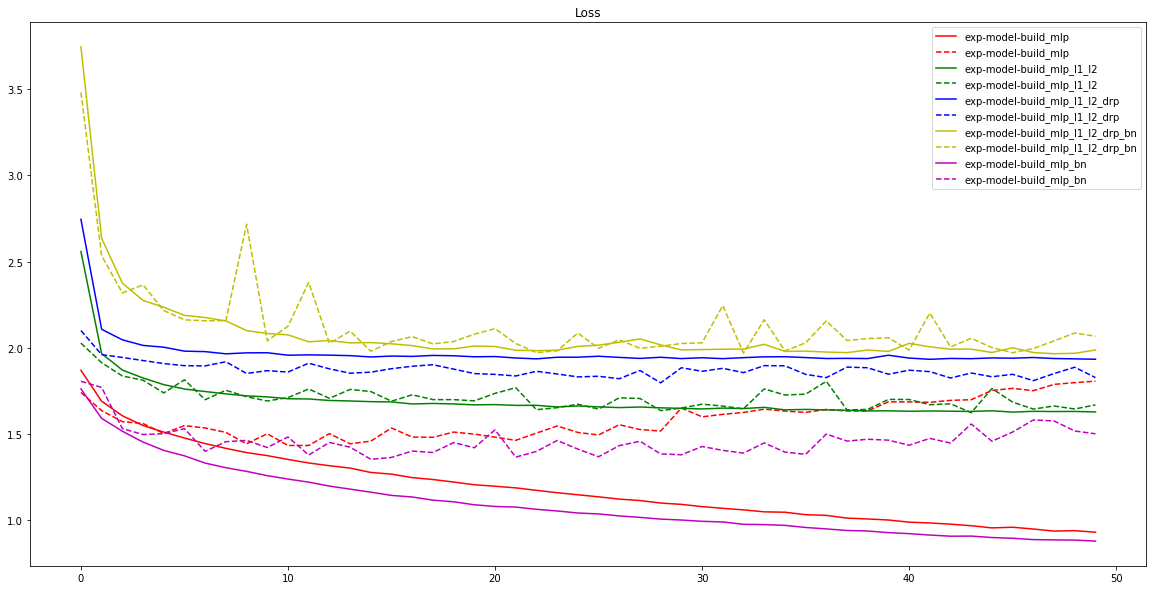

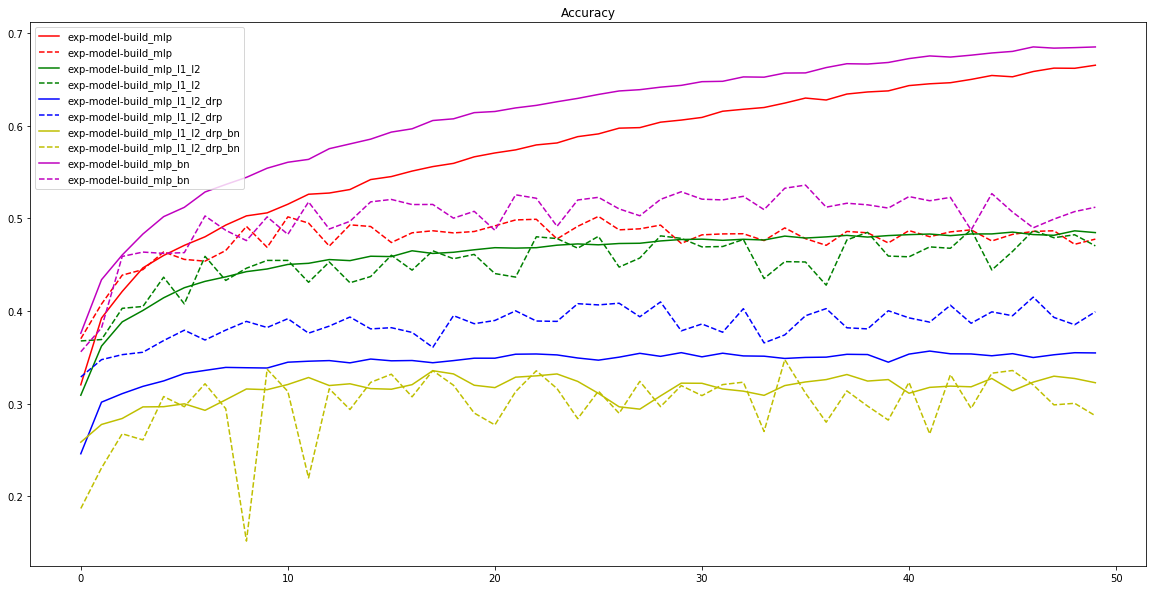

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
""" Code Here
    將結果繪出
"""

color_bar = ['r', 'g', 'b', 'y', 'm']

plt.figure(figsize=(20, 10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()